In [1]:
import urllib.request

url = "https://figshare.com/ndownloader/files/39181919" 
filename = "kf_2d_re1000_256_40seed.npy"    

urllib.request.urlretrieve(url, filename)
print(f"File downloaded and saved as {filename}")

url = "https://figshare.com/ndownloader/files/39214622" 
filename = "kmflow_sampled_data_irregnew.npz"     

urllib.request.urlretrieve(url, filename)
print(f"File downloaded and saved as {filename}")

File downloaded and saved as kf_2d_re1000_256_40seed.npy
File downloaded and saved as kmflow_sampled_data_irregnew.npz


In [1]:
import os 
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np 
import torch
import torch.nn as nn
from torch import optim
import random


In [2]:
class CustomDataset(Dataset):
    def __init__(self, image_LR, image_HR, transform=None):
        self.image_LR = image_LR
        self.image_HR = image_HR
        self.LR_Data_ar = np.load(self.image_LR)
        self.HR_Data_ar = np.load(self.image_HR, allow_pickle=True)
        
        self.LR_Data = self.LR_Data_ar['u3232'].reshape(-1, 256, 256)
        self.HR_Data = self.HR_Data_ar.reshape(-1, 256, 256)
        
        assert len(self.LR_Data) == len(self.HR_Data), "LR and HR datasets must have same length"
        
        self.transform = transform
        
    def __len__(self):
        return len(self.LR_Data)
    
    def __getitem__(self, idx):
        LR_image = self.LR_Data[idx]
        HR_image = self.HR_Data[idx]
        
        if self.transform:
            LR_image = self.transform(LR_image).float()  
            HR_image = self.transform(HR_image).float()  
        else:
            LR_image = torch.from_numpy(LR_image).float().unsqueeze(0)
            HR_image = torch.from_numpy(HR_image).float().unsqueeze(0)
            
        return LR_image, HR_image

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[-0.0011400291633424616], std=[4.7840316357035375])
])

HR_Data = 'kf_2d_re1000_256_40seed.npy'
LR_Data = 'kmflow_sampled_data_irregnew.npz'

dataset = CustomDataset(LR_Data, HR_Data, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
for LR_batch, HR_batch in dataloader:
    print(f"LR batch shape: {LR_batch.shape}")  
    print(f"HR batch shape: {HR_batch.shape}")  
    break
print(f"Min/Max LR: {LR_batch.min()} / {LR_batch.max()}")
print(f"Min/Max HR: {HR_batch.min()} / {HR_batch.max()}")


LR batch shape: torch.Size([32, 1, 256, 256])
HR batch shape: torch.Size([32, 1, 256, 256])
Min/Max LR: -4.110527038574219 / 4.371421813964844
Min/Max HR: -4.196133613586426 / 4.453355312347412


In [10]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np 
import torch
import torch.nn as nn
from torch import optim

In [26]:
class Res_Block(nn.Module):
    def __init__(self,in_channel,out_channel,kernel,padding,stride):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel,out_channels=out_channel,kernel_size=kernel,padding=padding,stride=stride)
        self.conv2 = nn.Conv2d(in_channels=out_channel,out_channels=out_channel,kernel_size=kernel,padding=padding,stride=stride)
        self.sk_conv = nn.Conv2d(in_channels=in_channel,out_channels=out_channel,kernel_size=kernel,padding=padding,stride=stride)
        self.active = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(out_channel)  
        self.bn2 = nn.BatchNorm2d(out_channel)
    def forward(self,x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.active(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        x2 = self.sk_conv(x)

        x_sk = x1+x2
        x_f = self.active(x_sk)
        return x_sk,x_f
        
        

In [12]:
class Down(nn.Module):
    def __init__(self):
        super().__init__()
        self.Res1 = Res_Block(64,64,3,1,1)
        self.Res2 = Res_Block(64,128,3,1,1)
        self.Res3 = Res_Block(128,256,3,1,1)
        self.mp = nn.MaxPool2d(3,2,1)
    def forward(self,x):
        x_sk1,xr1 = self.Res1(x)
        xr1 = self.mp(xr1)
        x_sk2,xr2 = self.Res2(xr1)
        xr2 = self.mp(xr2)
        x_sk3,xr3 = self.Res3(xr2)
        xr3 = self.mp(xr3)
        return xr3,x_sk1,x_sk2,x_sk3
        

In [13]:
class Up(nn.Module):
    def __init__(self):
        super().__init__()
        self.Res1 = Res_Block(256,256,3,1,1)
        self.Res2 = Res_Block(128,128,3,1,1)
        self.Res3 = Res_Block(64,64,3,1,1)
        self.convT1 = nn.ConvTranspose2d(512,256,2,2,0)
        self.convT2 = nn.ConvTranspose2d(256,128,2,2,0)
        self.convT3 = nn.ConvTranspose2d(128,64,2,2,0)
    def forward(self,x,x_sk1,x_sk2,x_sk3):
        x = self.convT1(x)
        x += x_sk3
        _,x = self.Res1(x)
        x = self.convT2(x)
        x += x_sk2
        _,x = self.Res2(x)
        x = self.convT3(x)
        x += x_sk1
        _,x = self.Res3(x)
        return x

In [27]:
class full_model(nn.Module):
    def __init__(self,in_channel,out_channel):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channel,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.convT = nn.ConvTranspose2d(in_channels=64,out_channels=out_channel,kernel_size=3,stride=1,padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.Res = Res_Block(256,512,3,1,1)
        self.Down = Down()
        self.Up = Up()
    def forward(self,x):
        x = self.conv(x)
        x = self.relu(x)
        x,x_sk1,x_sk2,x_sk3 = self.Down(x)
        _,x = self.Res(x)
        x = self.Up(x,x_sk1,x_sk2,x_sk3)
        x = self.convT(x)
        return x

In [ ]:
model = full_model(1,1)

x = torch.randn(32, 1, 512, 256)
y = model(x)
print(y.shape)  


In [41]:
def train_model(model, train_loader, optimizer, criterion, device,scheduler ,num_epochs=10):
    history = {'train_loss': []}
    model.to(device)
    model = model.float()  
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for LR_batch, HR_batch in train_loader:
            LR_batch = LR_batch.float().to(device) 
            HR_batch = HR_batch.float().to(device)  
            
            optimizer.zero_grad()
            outputs = model(LR_batch)
            loss = criterion(outputs, HR_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
            optimizer.step()
            
            train_loss += loss.item() * LR_batch.size(0)
            # print(f'Epoch: {epoch+1}/{num_epochs} Train Loss: {loss.item():.4f}')
        avg_train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_train_loss)
        scheduler.step(avg_train_loss)
        
        print(f'Epoch: {epoch+1}/{num_epochs} Train Loss: {avg_train_loss:.4f}')
        
    return history,model

In [66]:
model = full_model(1,1).float()  
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = nn.MSELoss()
# criterion = nn.L1Loss()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history,model_f = train_model(
    model=model,
    train_loader=dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    scheduler=scheduler,
    num_epochs=20
)

Epoch: 1/20 Train Loss: 0.6551
Epoch: 2/20 Train Loss: 0.1495
Epoch: 3/20 Train Loss: 0.1278
Epoch: 4/20 Train Loss: 0.1183
Epoch: 5/20 Train Loss: 0.1119
Epoch: 6/20 Train Loss: 0.1069
Epoch: 7/20 Train Loss: 0.1026
Epoch: 8/20 Train Loss: 0.0989
Epoch: 9/20 Train Loss: 0.0958
Epoch: 10/20 Train Loss: 0.0931
Epoch: 11/20 Train Loss: 0.0905
Epoch: 12/20 Train Loss: 0.0884
Epoch: 13/20 Train Loss: 0.0863
Epoch: 14/20 Train Loss: 0.0845
Epoch: 15/20 Train Loss: 0.0827
Epoch: 16/20 Train Loss: 0.0812
Epoch: 17/20 Train Loss: 0.0794
Epoch: 18/20 Train Loss: 0.0778
Epoch: 19/20 Train Loss: 0.0763
Epoch: 20/20 Train Loss: 0.0752


In [67]:
def output(dataloader, model, n=10):
    for LR_batch, HR_batch in dataloader:
        break

    batch_size = LR_batch.shape[0]
    sample_indices = random.sample(range(batch_size), min(n, batch_size))

    LR_samples = LR_batch[sample_indices].float().to(device)
    HR_samples = HR_batch[sample_indices].float().to(device)

    model.eval()
    with torch.no_grad():
        output_samples = model(LR_samples)

    all_imgs = torch.cat([LR_samples, HR_samples], dim=0)
    vmin = all_imgs.min().item()
    vmax = all_imgs.max().item()

    # Plot LR
    fig, axs = plt.subplots(1, len(LR_samples), figsize=(15, 3))
    for i, ax in enumerate(axs):
        im = ax.imshow(LR_samples[i].squeeze().cpu().numpy(), cmap='jet', vmin=vmin, vmax=vmax)
        ax.set_title(f'LR Input {i}')
        ax.axis('off')
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)

    # Plot Output
    fig, axs = plt.subplots(1, len(output_samples), figsize=(15, 3))
    for i, ax in enumerate(axs):
        im = ax.imshow(output_samples[i].squeeze().cpu().numpy(), cmap='jet', vmin=vmin, vmax=vmax)
        ax.set_title(f'HR Output {i}')
        ax.axis('off')
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)

    # Plot HR
    fig, axs = plt.subplots(1, len(HR_samples), figsize=(15, 3))
    for i, ax in enumerate(axs):
        im = ax.imshow(HR_samples[i].squeeze().cpu().numpy(), cmap='jet', vmin=vmin, vmax=vmax)
        ax.set_title(f'Ground Truth {i}')
        ax.axis('off')
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
    plt.show()


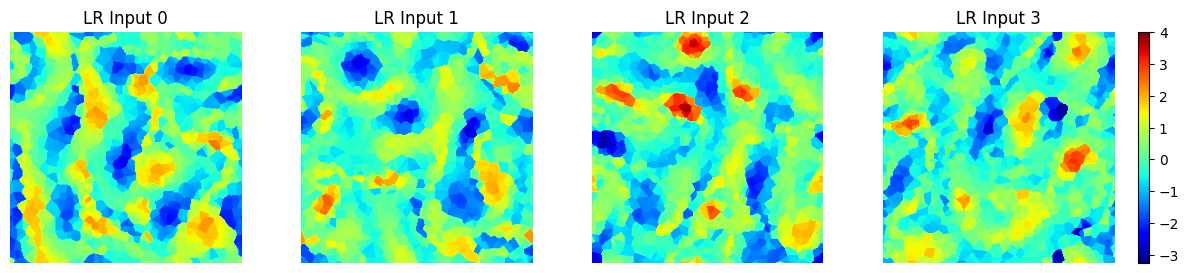

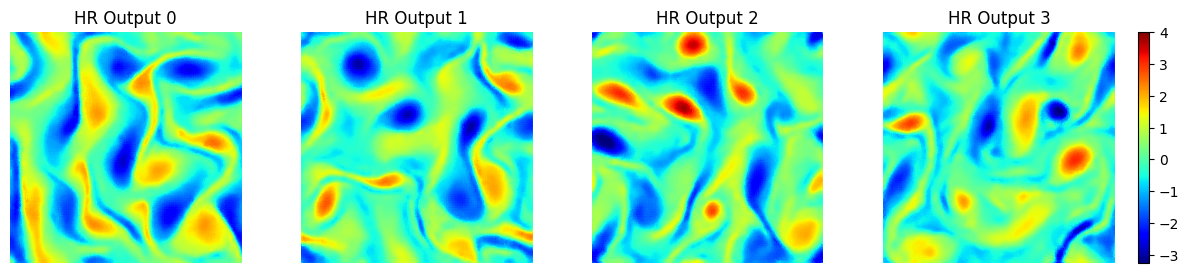

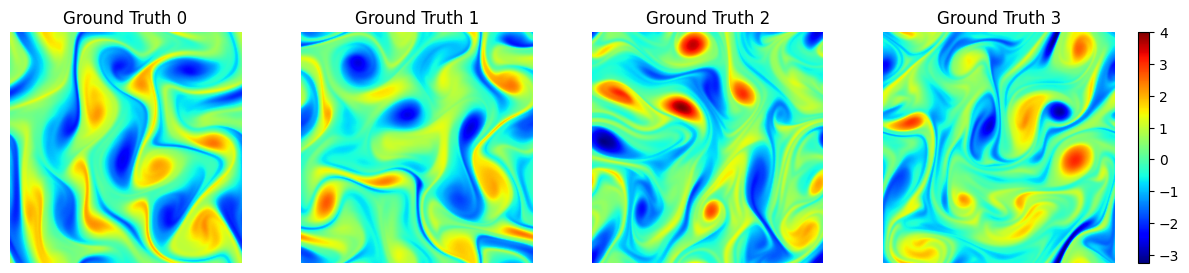

In [68]:
output(dataloader, model,n=4)

In [69]:
torch.save(model_f.state_dict(), "/kaggle/working/model_weights.pth")

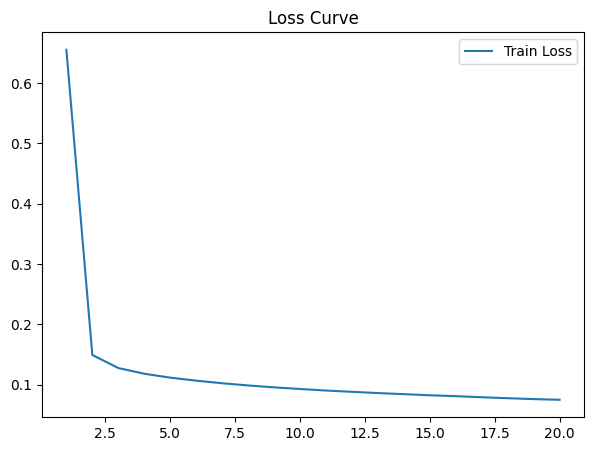

In [70]:
plt.figure(figsize=(7, 5))
x = np.arange(1,20+1,1)
plt.plot(x,history['train_loss'], label='Train Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [71]:
history2,model_f = train_model(
    model=model,
    train_loader=dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    scheduler=scheduler,
    num_epochs=20
)

Epoch: 1/20 Train Loss: 0.0736
Epoch: 2/20 Train Loss: 0.0726
Epoch: 3/20 Train Loss: 0.0713
Epoch: 4/20 Train Loss: 0.0703
Epoch: 5/20 Train Loss: 0.0691
Epoch: 6/20 Train Loss: 0.0679
Epoch: 7/20 Train Loss: 0.0670
Epoch: 8/20 Train Loss: 0.0663
Epoch: 9/20 Train Loss: 0.0652
Epoch: 10/20 Train Loss: 0.0644
Epoch: 11/20 Train Loss: 0.0634
Epoch: 12/20 Train Loss: 0.0625
Epoch: 13/20 Train Loss: 0.0618
Epoch: 14/20 Train Loss: 0.0609
Epoch: 15/20 Train Loss: 0.0600
Epoch: 16/20 Train Loss: 0.0594
Epoch: 17/20 Train Loss: 0.0587
Epoch: 18/20 Train Loss: 0.0580
Epoch: 19/20 Train Loss: 0.0574
Epoch: 20/20 Train Loss: 0.0566


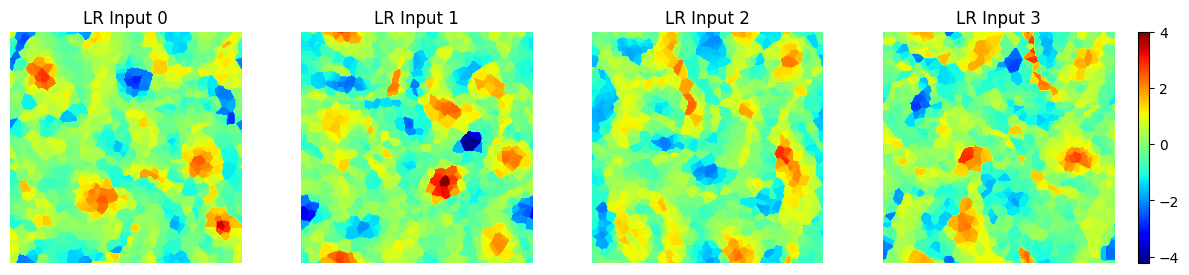

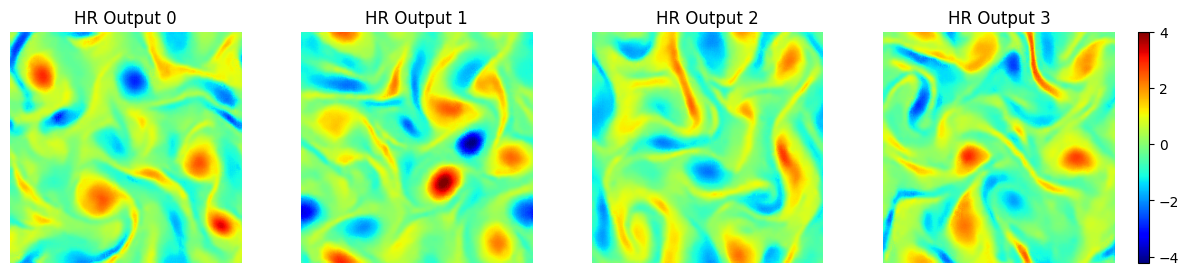

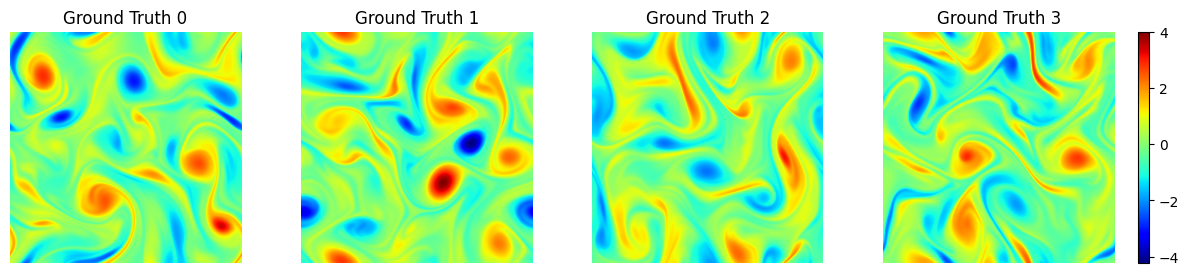

In [72]:
output(dataloader, model,n=4)

In [73]:
torch.save(model_f.state_dict(), "/kaggle/working/model_weights2.pth")

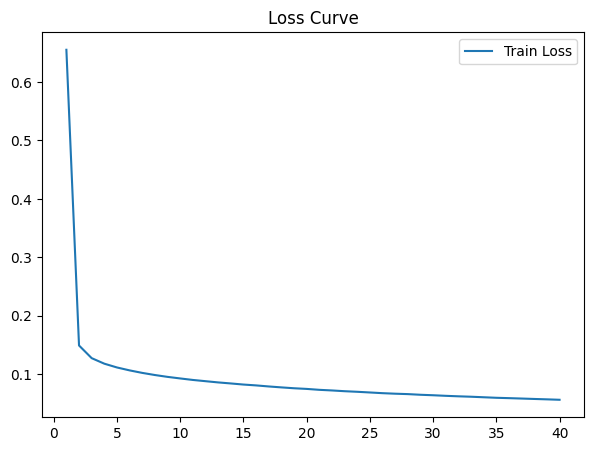

In [75]:
plt.figure(figsize=(7, 5))
x = np.arange(1,40+1,1)
plt.plot(x,history['train_loss']+history2['train_loss'], label='Train Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()